In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Fri Jan 26 17:07:36 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   37C    P0    44W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4_quantize200/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


In [7]:
path = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4/save_600000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))
# warm start
for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
    model.load_state_dict(checkpoint['models_state_dict'][i], strict=False)
    
print('done')

done


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

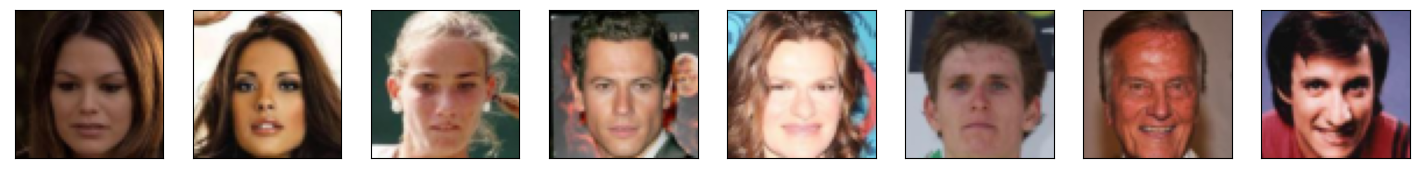

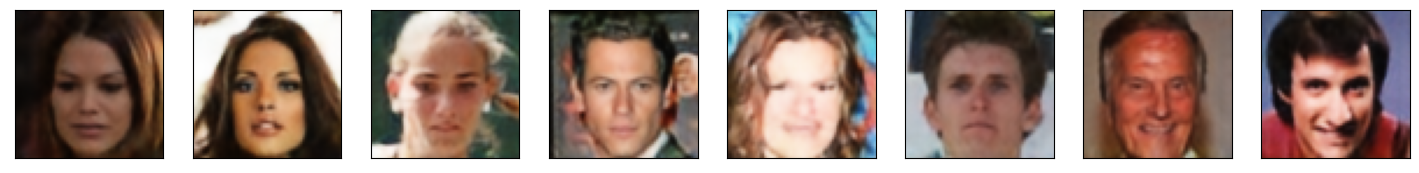

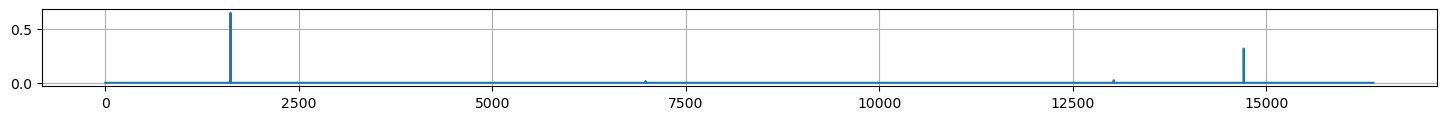

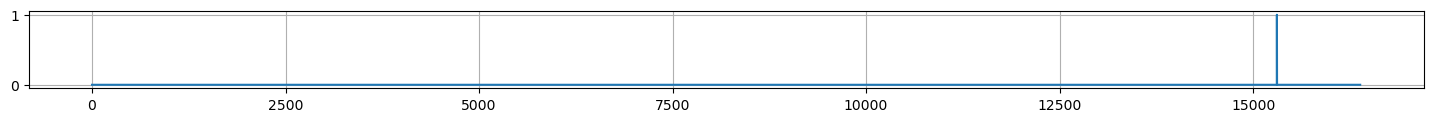

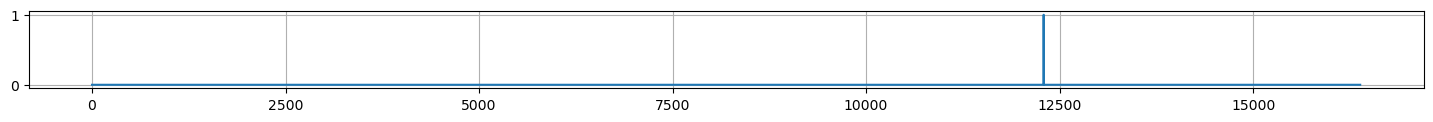

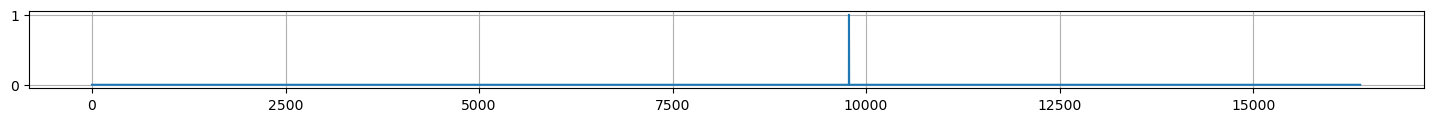

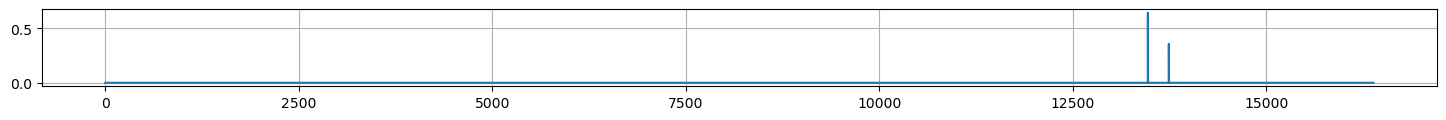

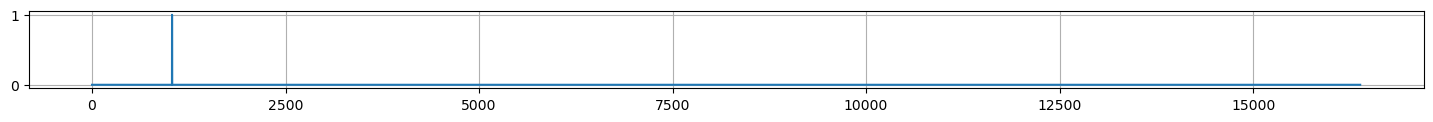

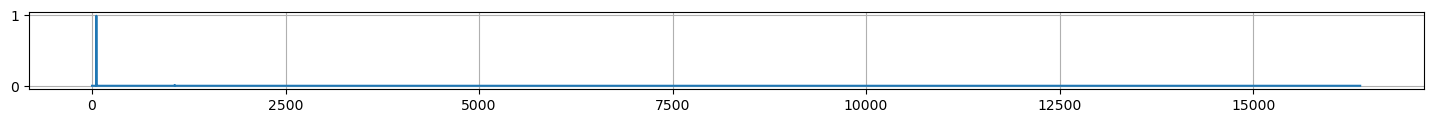

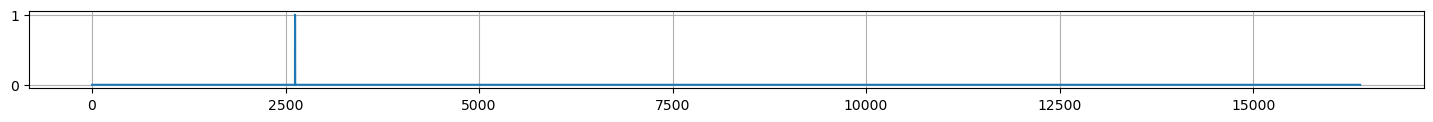

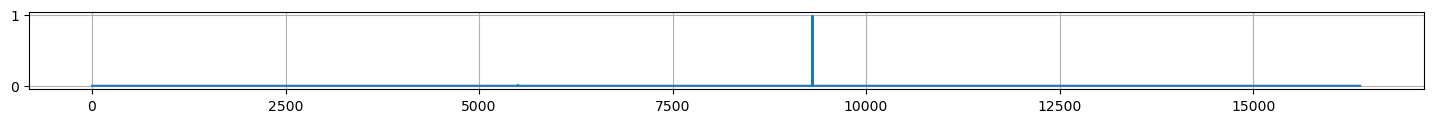

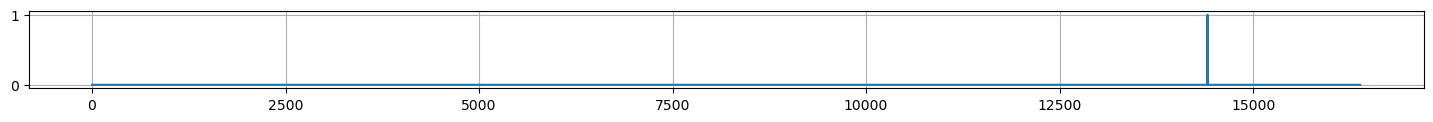

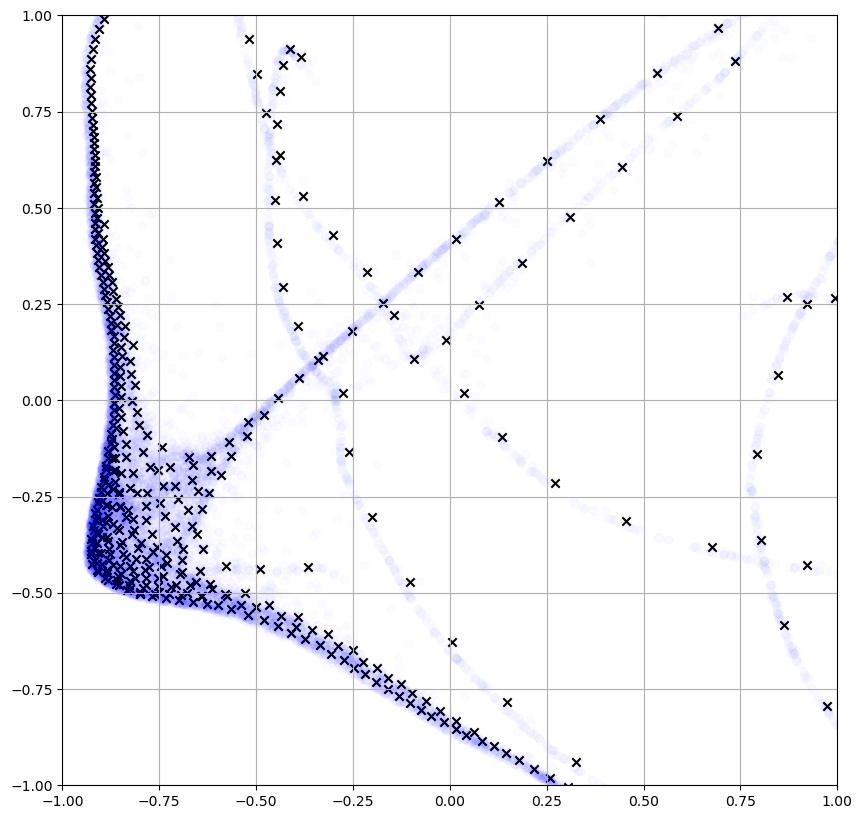

2001
lse_loss -407.9085388183594
commit_loss 8.181513840099797e-05
recon_loss 0.0008166072657331824
2002
lse_loss -407.46044921875
commit_loss 7.472642755601555e-05
recon_loss 0.0007404398056678474
2003
lse_loss -397.4336242675781
commit_loss 7.697146793361753e-05
recon_loss 0.0008009548182599247
2004
lse_loss -408.3319396972656
commit_loss 7.464481313945726e-05
recon_loss 0.0007526175468228757
2005
lse_loss -409.5464782714844
commit_loss 7.342291792156175e-05
recon_loss 0.0007223954889923334
2006
lse_loss -408.16510009765625
commit_loss 7.27857113815844e-05
recon_loss 0.0006835123058408499
2007
lse_loss -408.7216491699219
commit_loss 7.551643648184836e-05
recon_loss 0.0007087361882440746
2008
lse_loss -405.99041748046875
commit_loss 7.331221422646195e-05
recon_loss 0.0007304525934159756
2009
lse_loss -410.3887939453125
commit_loss 7.470098353223875e-05
recon_loss 0.0006436225958168507
2010
lse_loss -407.62786865234375
commit_loss 7.35372377675958e-05
recon_loss 0.0007115759653970599
2

2085
lse_loss -407.274658203125
commit_loss 7.964901305967942e-05
recon_loss 0.0008174692047759891
2086
lse_loss -399.9327697753906
commit_loss 7.915191235952079e-05
recon_loss 0.000719742733053863
2087
lse_loss -404.52655029296875
commit_loss 7.765578629914671e-05
recon_loss 0.0006951524410396814
2088
lse_loss -407.42620849609375
commit_loss 7.981780800037086e-05
recon_loss 0.0006978408200666308
2089
lse_loss -402.3595275878906
commit_loss 8.04946175776422e-05
recon_loss 0.0007562753744423389
2090
lse_loss -409.7428283691406
commit_loss 7.563874532934278e-05
recon_loss 0.0007826811634004116
2091
lse_loss -406.99725341796875
commit_loss 7.575265044579282e-05
recon_loss 0.000776716391555965
2092
lse_loss -409.0168151855469
commit_loss 7.612118497490883e-05
recon_loss 0.0006495347479358315
2093
lse_loss -407.03338623046875
commit_loss 8.202833123505116e-05
recon_loss 0.0007211134652607143
2094
lse_loss -406.27386474609375
commit_loss 8.41909641167149e-05
recon_loss 0.000976382230874151
2

lse_loss -400.3013916015625
commit_loss 8.09009070508182e-05
recon_loss 0.0007718557026237249
2169
lse_loss -393.51434326171875
commit_loss 8.670815441291779e-05
recon_loss 0.0008673953707329929
2170
lse_loss -413.4811706542969
commit_loss 8.202443132176995e-05
recon_loss 0.0007193577475845814
2171
lse_loss -411.0738525390625
commit_loss 8.10454657766968e-05
recon_loss 0.0007533382158726454
2172
lse_loss -399.647705078125
commit_loss 7.575243944302201e-05
recon_loss 0.0007482267683371902
2173
lse_loss -401.4424743652344
commit_loss 8.551580685889348e-05
recon_loss 0.0008077311213128269
2174
lse_loss -410.12908935546875
commit_loss 8.151942165568471e-05
recon_loss 0.0008221114985644817
2175
lse_loss -393.3774108886719
commit_loss 8.219062874559313e-05
recon_loss 0.000821628316771239
2176
lse_loss -410.3943786621094
commit_loss 8.304823859361932e-05
recon_loss 0.000771674676798284
2177
lse_loss -409.9347229003906
commit_loss 8.470081957057118e-05
recon_loss 0.0007684910669922829
2178
lse

2251
lse_loss -406.4436340332031
commit_loss 8.069351315498352e-05
recon_loss 0.0008284408831968904
2252
lse_loss -408.6722106933594
commit_loss 8.326897659571841e-05
recon_loss 0.000711554370354861
2253
lse_loss -405.9807434082031
commit_loss 7.573829498142004e-05
recon_loss 0.0007832695264369249
2254
lse_loss -398.4891357421875
commit_loss 8.08696131571196e-05
recon_loss 0.0007850311230868101
2255
lse_loss -405.9044189453125
commit_loss 7.369894592557102e-05
recon_loss 0.0006379917613230646
2256
lse_loss -400.0396728515625
commit_loss 8.605398761574179e-05
recon_loss 0.000804421491920948
2257
lse_loss -408.4726867675781
commit_loss 7.841271872166544e-05
recon_loss 0.0008153637172654271
2258
lse_loss -408.4097900390625
commit_loss 7.706605538260192e-05
recon_loss 0.0006775699439458549
2259
lse_loss -410.340576171875
commit_loss 8.227523358073086e-05
recon_loss 0.0007316293194890022
2260
lse_loss -402.19976806640625
commit_loss 7.964093674672768e-05
recon_loss 0.0007486483082175255
226

2336
lse_loss -407.4007263183594
commit_loss 7.58048117859289e-05
recon_loss 0.00076663977233693
2337
lse_loss -389.9256286621094
commit_loss 7.435616862494498e-05
recon_loss 0.0008923278073780239
2338
lse_loss -408.5875549316406
commit_loss 7.785935304127634e-05
recon_loss 0.0008104199077934027
2339
lse_loss -405.70404052734375
commit_loss 7.818279846105725e-05
recon_loss 0.0008278470486402512
2340
lse_loss -391.98992919921875
commit_loss 7.51114494050853e-05
recon_loss 0.0009610156412236392
2341
lse_loss -403.5951232910156
commit_loss 7.784628542140126e-05
recon_loss 0.0008214439731091261
2342
lse_loss -404.3575439453125
commit_loss 7.750441727694124e-05
recon_loss 0.0007964138640090823
2343
lse_loss -408.5870361328125
commit_loss 7.117177301552147e-05
recon_loss 0.0007455706363543868
2344
lse_loss -404.5105285644531
commit_loss 7.687487232033163e-05
recon_loss 0.0008175069815479219
2345
lse_loss -406.8896484375
commit_loss 7.68740865169093e-05
recon_loss 0.000786781485658139
2346
ls

2421
lse_loss -402.7007751464844
commit_loss 7.419437315547839e-05
recon_loss 0.0008007576689124107
2422
lse_loss -404.234130859375
commit_loss 7.322496821871027e-05
recon_loss 0.0007423536735586822
2423
lse_loss -397.5012512207031
commit_loss 7.797287253197283e-05
recon_loss 0.0007764752954244614
2424
lse_loss -407.2791442871094
commit_loss 7.395957072731107e-05
recon_loss 0.0006754991482011974
2425
lse_loss -403.7646789550781
commit_loss 7.464870577678084e-05
recon_loss 0.0007596443756483495
2426
lse_loss -409.51861572265625
commit_loss 7.42837946745567e-05
recon_loss 0.0007725564646534622
2427
lse_loss -405.88134765625
commit_loss 7.340558659052476e-05
recon_loss 0.0007180941756814718
2428
lse_loss -407.69500732421875
commit_loss 7.072628068272024e-05
recon_loss 0.0006816674722358584
2429
lse_loss -409.2908020019531
commit_loss 7.640388503205031e-05
recon_loss 0.0007098644855432212
2430
lse_loss -401.5022888183594
commit_loss 7.740745786577463e-05
recon_loss 0.0008111902279779315
24

2505
lse_loss -410.7060241699219
commit_loss 7.840412581572309e-05
recon_loss 0.0007303300080820918
2506
lse_loss -406.8830261230469
commit_loss 7.000544428592548e-05
recon_loss 0.0007160793757066131
2507
lse_loss -407.431396484375
commit_loss 7.544200343545526e-05
recon_loss 0.0007263431325554848
2508
lse_loss -410.7348327636719
commit_loss 7.315355469472706e-05
recon_loss 0.0008261050097644329
2509
lse_loss -407.9949951171875
commit_loss 7.130244193831459e-05
recon_loss 0.0008144197054207325
2510
lse_loss -413.3288269042969
commit_loss 7.115054177120328e-05
recon_loss 0.0007819144520908594
2511
lse_loss -406.5807800292969
commit_loss 7.200302206911147e-05
recon_loss 0.0008062992710620165
2512
lse_loss -407.5897216796875
commit_loss 7.354861736530438e-05
recon_loss 0.0007878078031353652
2513
lse_loss -407.78338623046875
commit_loss 7.10991516825743e-05
recon_loss 0.0008463765843771398
2514
lse_loss -406.45111083984375
commit_loss 7.370173261733726e-05
recon_loss 0.0007530145230703056


lse_loss -407.4907531738281
commit_loss 7.398830348392949e-05
recon_loss 0.0008406054694205523
2588
lse_loss -407.0242004394531
commit_loss 8.060404798015952e-05
recon_loss 0.0007949058781377971
2589
lse_loss -404.5118713378906
commit_loss 7.381583418464288e-05
recon_loss 0.0008554859086871147
2590
lse_loss -411.1538391113281
commit_loss 7.720597204752266e-05
recon_loss 0.0008620120352134109
2591
lse_loss -397.2438659667969
commit_loss 7.693927182117477e-05
recon_loss 0.0007782350294291973
2592
lse_loss -404.7566833496094
commit_loss 7.856999582145363e-05
recon_loss 0.0008908131858333945
2593
lse_loss -409.2353210449219
commit_loss 7.705582538619637e-05
recon_loss 0.0007580233504995704
2594
lse_loss -389.6619567871094
commit_loss 7.757139974273741e-05
recon_loss 0.0006880600703880191
2595
lse_loss -407.4767150878906
commit_loss 7.76253073127009e-05
recon_loss 0.000864898320287466
2596
lse_loss -401.8432922363281
commit_loss 8.780734788160771e-05
recon_loss 0.0008670259267091751
2597
ls

2670
lse_loss -412.1191101074219
commit_loss 7.919099880382419e-05
recon_loss 0.0008163177408277988
2671
lse_loss -408.3357849121094
commit_loss 8.084022556431592e-05
recon_loss 0.0008441677200607955
2672
lse_loss -403.89593505859375
commit_loss 7.868492684792727e-05
recon_loss 0.000718864961527288
2673
lse_loss -409.052490234375
commit_loss 7.933456072350964e-05
recon_loss 0.0007894586306065321
2674
lse_loss -412.9012756347656
commit_loss 7.887839456088841e-05
recon_loss 0.0007242897991091013
2675
lse_loss -408.5268249511719
commit_loss 8.263611380243674e-05
recon_loss 0.0008741632918827236
2676
lse_loss -408.42291259765625
commit_loss 7.51206316635944e-05
recon_loss 0.0008246824145317078
2677
lse_loss -411.3472900390625
commit_loss 7.972802268341184e-05
recon_loss 0.0008436682401224971
2678
lse_loss -410.01055908203125
commit_loss 7.42343909223564e-05
recon_loss 0.000772722705733031
2679
lse_loss -406.0102844238281
commit_loss 7.981148519320413e-05
recon_loss 0.0007515297620557249
26

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            quant_temp = linear(1, 0, step, 0, 200*1000)
            data = model(data, latent_temp=1, quant_temp=quant_temp)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 